In [ ]:
# Cell 1 — upload spe9.zip (or a single .DATA file)
from google.colab import files
import zipfile, os, io, shutil

print("Upload spe9.zip (recommended) or SPE9CASE1.DATA directly.")
uploaded = files.upload()

# If zip file uploaded, extract to /content/SPE9_data
base_dir = "/content/SPE9_data"
os.makedirs(base_dir, exist_ok=True)

for fn in uploaded.keys():
    if fn.lower().endswith(".zip"):
        print("Extracting", fn)
        with zipfile.ZipFile(fn, 'r') as z:
            z.extractall(base_dir)
    else:
        # Save single file
        fp = os.path.join(base_dir, fn)
        with open(fp, "wb") as f:
            f.write(uploaded[fn])
        print("Saved", fp)

print("\nTop-level listing:")
for p in os.listdir(base_dir):
    print("-", p)


Upload spe9.zip (recommended) or SPE9CASE1.DATA directly.


Saving spe9.zip to spe9 (1).zip
Extracting spe9 (1).zip

Top-level listing:
- spe9


In [ ]:
# Cell 2 — search for SWOF / SGOF / PCOW / PCGO blocks in all files
import os, glob, re
root = "/content/SPE9_data"

def find_blocks_in_file(path, keywords=("SWOF","SGOF","PCOW","PCGO")):
    found = {}
    try:
        txt = open(path, 'r', errors='ignore').read()
    except Exception as e:
        return found
    txt_u = txt.upper()
    for kw in keywords:
        matches = re.finditer(rf"{kw}\s*(.*?)\s*/", txt_u, re.S)
        blocks = [m.group(1).strip() for m in matches]
        if blocks:
            found[kw] = blocks
    return found

all_found = {}
for p in glob.glob(os.path.join(root, '**', '*'), recursive=True):
    if os.path.isfile(p):
        blocks = find_blocks_in_file(p)
        if blocks:
            all_found[p] = {k: len(v) for k,v in blocks.items()}

if not all_found:
    print("No SWOF/SGOF/PC blocks found in", root)
else:
    print("Found SCAL blocks in these files:")
    for p, summary in all_found.items():
        print("\nFile:", p)
        for k,c in summary.items():
            print("  ", k, "count:", c)


Found SCAL blocks in these files:

File: /content/SPE9_data/spe9/SPE9_CP_SHORT_RESTART.DATA
   SWOF count: 2
   SGOF count: 2

File: /content/SPE9_data/spe9/SPE9_CP_SHORT.DATA
   SWOF count: 2
   SGOF count: 2

File: /content/SPE9_data/spe9/SPE9_CP_GROUP.DATA
   SWOF count: 2
   SGOF count: 2

File: /content/SPE9_data/spe9/SPE9.DATA
   SWOF count: 2
   SGOF count: 2

File: /content/SPE9_data/spe9/SPE9_CP.DATA
   SWOF count: 2
   SGOF count: 2


In [ ]:
# Cell 3 — helper functions: extract nth block text and convert to DataFrame
import re, pandas as pd

def extract_block_text(path, keyword, index=0):
    txt = open(path, 'r', errors='ignore').read()
    txt_u = txt.upper()
    pattern = rf"{keyword}\s*(.*?)\s*/"
    matches = re.findall(pattern, txt_u, re.S)
    if len(matches) > index:
        return matches[index]
    return None

def block_to_df(block_text):
    rows = []
    for line in block_text.splitlines():
        line = line.strip()
        if not line or line.startswith('--') or line.startswith('*'):
            continue
        # find numeric tokens including scientific notation
        toks = re.findall(r"[-+]?\d*\.\d+|\d+\.?\d*(?:[Ee][-+]?\d+)?", line)
        if len(toks) >= 4:
            rows.append([float(toks[0]), float(toks[1]), float(toks[2]), float(toks[3])])
    if not rows:
        return pd.DataFrame(columns=["Sat","kr1","kr2","Pc"])
    return pd.DataFrame(rows, columns=["Sat","kr1","kr2","Pc"])

# ---------- Choose the file and blocks ----------
# If the find-blocks step printed files, change 'deck_path' to that full path.
# Example:
# deck_path = "/content/SPE9_data/spe9/SPE9CASE1.DATA"
# If there are multiple files, you can loop them - here we'll attempt CASE1 automaticaly.

import os, glob
deck_candidates = glob.glob(os.path.join("/content/SPE9_data","**","*.DATA"), recursive=True)
if not deck_candidates:
    # fallback: any file found in directory
    deck_candidates = glob.glob(os.path.join("/content/SPE9_data","**","*"), recursive=True)

# pick first .DATA-like file
deck_path = deck_candidates[0]
print("Using deck:", deck_path)

# extract first SWOF and SGOF blocks if present
swof_text = extract_block_text(deck_path, "SWOF", index=0)
sgof_text = extract_block_text(deck_path, "SGOF", index=0)

df_swof = block_to_df(swof_text) if swof_text else pd.DataFrame(columns=["Sat","kr1","kr2","Pc"])
df_sgof = block_to_df(sgof_text) if sgof_text else pd.DataFrame(columns=["Sat","kr1","kr2","Pc"])

print("\nSWOF rows:", len(df_swof))
display(df_swof.head(10))
print("\nSGOF rows:", len(df_sgof))
display(df_sgof.head(10))


Using deck: /content/SPE9_data/spe9/SPE9_CP_SHORT_RESTART.DATA

SWOF rows: 0


,Sat,kr1,kr2,Pc



SGOF rows: 10


,Sat,kr1,kr2,Pc
0,0.00000,0.0000,1.00,0.00
1,0.04000,0.0000,0.60,0.20
2,0.10000,0.0220,0.33,0.50
3,0.20000,0.1000,0.10,1.00
4,0.30000,0.2400,0.02,1.50
5,0.40000,0.3400,0.00,2.00
6,0.50000,0.4200,0.00,2.50
7,0.60000,0.5000,0.00,3.00
8,0.70000,0.8125,0.00,3.50
9,0.84891,0.9635,0.00,3.82


In [ ]:
# Cell 4 — quick checks and estimated endpoints
import numpy as np

def estimate_endpoints(df, small1=1e-9, small2=1e-6):
    if df.empty:
        return None,None
    S = df['Sat'].values
    k1 = df['kr1'].values
    k2 = df['kr2'].values
    # Swi: first S where k1 > small1
    try:
        Swi = float(S[k1 > small1].min())
    except:
        Swi = float(S.min())
    # Sor: 1 - max S where k2 > small2
    try:
        S_k2_nonzero_max = float(S[k2 > small2].max())
        Sor = 1.0 - S_k2_nonzero_max
    except:
        Sor = 1.0 - float(S.max())
    return Swi, Sor

swi, sor = estimate_endpoints(df_swof)
print("Estimated SWOF endpoints: Swi =", swi, " Sor =", sor)

if not df_sgof.empty:
    sgc, sorg = estimate_endpoints(df_sgof)
    print("Estimated SGOF endpoints: Sgc =", sgc, " Sorg =", sorg)
else:
    print("No SGOF found; continuing with SWOF only.")


Estimated SWOF endpoints: Swi = None  Sor = None
Estimated SGOF endpoints: Sgc = 0.1  Sorg = 0.7


SPE9 SWOF rows: 0
Empty DataFrame
Columns: [Sat, kr1, kr2, Pc]
Index: []

SPE9 SGOF rows: 10
    Sat    kr1   kr2   Pc
0  0.00  0.000  1.00  0.0
1  0.04  0.000  0.60  0.2
2  0.10  0.022  0.33  0.5
3  0.20  0.100  0.10  1.0
4  0.30  0.240  0.02  1.5


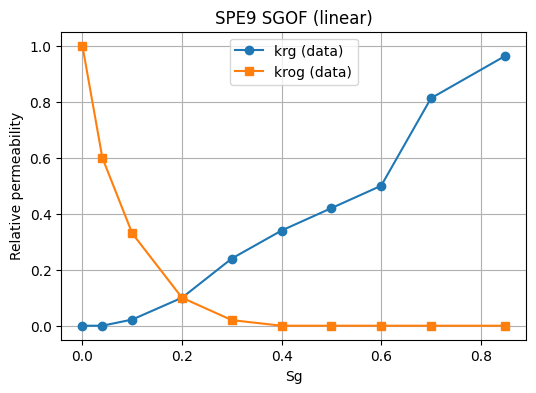

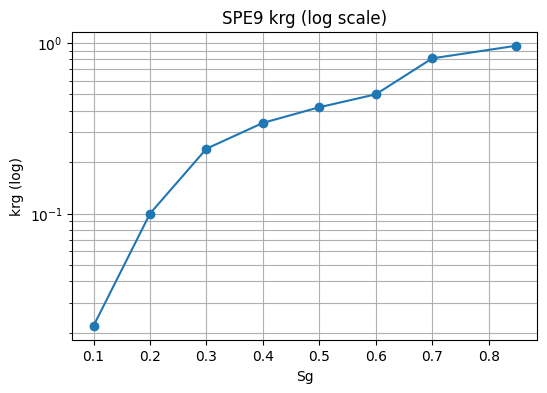

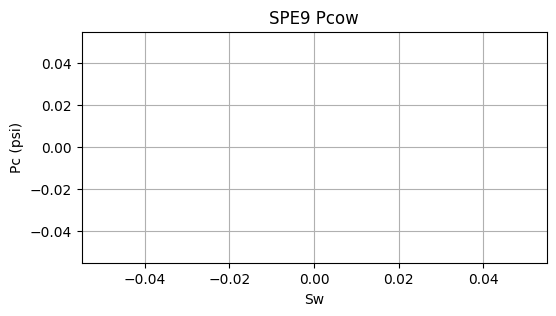

In [ ]:
# Paste into Colab (run in the same notebook where df_swof, df_sgof, results exist)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure df_swof/df_sgof exist
print("SPE9 SWOF rows:", len(df_swof))
print(df_swof.head())
print("\nSPE9 SGOF rows:", len(df_sgof))
print(df_sgof.head())

# Plot SWOF linear (if present)
if len(df_swof)>0:
    plt.figure(figsize=(6,4))
    plt.plot(df_swof['Sat'], df_swof['kr1'], 'o-', label='krw (data)')
    plt.plot(df_swof['Sat'], df_swof['kr2'], 's-', label='kro (data)')
    plt.xlabel('Sw'); plt.ylabel('Relative permeability'); plt.title('SPE9 SWOF (linear)')
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    # avoid zeros for semilogy by replacing 0 with nan
    krw_nonzero = df_swof['kr1'].replace(0, np.nan)
    plt.semilogy(df_swof['Sat'], krw_nonzero, 'o-', label='krw (log)')
    plt.xlabel('Sw'); plt.ylabel('krw (log)'); plt.title('SPE9 krw (log scale)')
    plt.grid(True, which='both'); plt.show()

# Plot SGOF linear (if present)
if len(df_sgof)>0:
    plt.figure(figsize=(6,4))
    plt.plot(df_sgof['Sat'], df_sgof['kr1'], 'o-', label='krg (data)')
    plt.plot(df_sgof['Sat'], df_sgof['kr2'], 's-', label='krog (data)')
    plt.xlabel('Sg'); plt.ylabel('Relative permeability'); plt.title('SPE9 SGOF (linear)')
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    krg_nonzero = df_sgof['kr1'].replace(0, np.nan)
    plt.semilogy(df_sgof['Sat'], krg_nonzero, 'o-')
    plt.xlabel('Sg'); plt.ylabel('krg (log)'); plt.title('SPE9 krg (log scale)')
    plt.grid(True, which='both'); plt.show()

# Plot Pc if present (use SWOF pc column)
if 'Pc' in df_swof.columns:
    plt.figure(figsize=(6,3))
    plt.plot(df_swof['Sat'], df_swof['Pc'], 'o-')
    plt.xlabel('Sw'); plt.ylabel('Pc (psi)'); plt.title('SPE9 Pcow'); plt.grid(True); plt.show()


Estimated Sgc, Sorg: 0.1 0.7
krg fit (log): ng, krg0 = 0.10569600108323335 0.3946598708488083
krog fit (lin): no_g, krog0 = 2.6855664416631475 0.6433333333350659


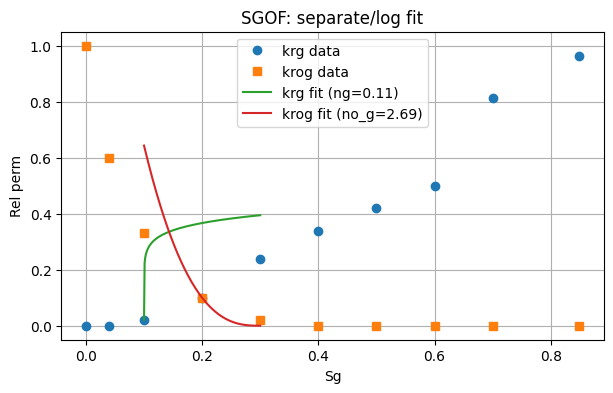

In [ ]:
# Paste into Colab (same notebook, where df_sgof exists)
import numpy as np, pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from math import sqrt

df = df_sgof.copy().reset_index(drop=True)  # Sg, kr1=krg, kr2=krog

S = df['Sat'].values
krg = df['kr1'].values
krog = df['kr2'].values

# estimate endpoints
def estimate_endpoints(S, k1, k2, t1=1e-9, t2=1e-6):
    Swi = float(S[k1 > t1].min()) if np.any(k1 > t1) else float(S.min())
    S_k2_max = float(S[k2 > t2].max()) if np.any(k2 > t2) else float(S.max())
    Sor = 1.0 - S_k2_max
    return Swi, Sor

Sgc, Sorg = estimate_endpoints(S, krg, krog)
print("Estimated Sgc, Sorg:", Sgc, Sorg)

# 1) fit krg in log-space: krg = krg0 * Se^ng
def res_krg_log(p):
    ng, krg0 = p
    Se = (S - Sgc) / (1 - Sgc - Sorg)
    Se = np.clip(Se, 1e-12, 1-1e-12)
    pred = krg0 * Se**ng
    # use log residual where krg>0, else compare absolute
    mask = krg > 0
    res = np.empty_like(krg)
    res[mask] = np.log(pred[mask]) - np.log(krg[mask])
    res[~mask] = pred[~mask] - krg[~mask]
    return res

init = [2.0, max(krg.max(), 0.2)]
bnds = ([0.1, 1e-6], [10, 5])
r1 = least_squares(res_krg_log, init, bounds=bnds)
ng, krg0 = r1.x
print("krg fit (log): ng, krg0 =", ng, krg0)

# 2) fit krog in linear space: krog = krog0 * (1-Se)^no
def res_krog_lin(p):
    no, krog0 = p
    Se = (S - Sgc) / (1 - Sgc - Sorg)
    Se = np.clip(Se, 1e-12, 1-1e-12)
    pred = krog0 * (1 - Se)**no
    return pred - krog

init2 = [2.0, max(krog.max(), 0.5)]
bnds2 = ([0.1, 1e-6], [10, 5])
r2 = least_squares(res_krog_lin, init2, bounds=bnds2)
no_g, krog0 = r2.x
print("krog fit (lin): no_g, krog0 =", no_g, krog0)

# plot results
Sgrid = np.linspace(Sgc, 1-Sorg, 201)
Se_grid = (Sgrid - Sgc) / (1 - Sgc - Sorg)
Se_grid = np.clip(Se_grid, 1e-12, 1-1e-12)
krg_fit = krg0 * Se_grid**ng
krog_fit = krog0 * (1-Se_grid)**no_g

plt.figure(figsize=(7,4))
plt.plot(S, krg, 'o', label='krg data')
plt.plot(S, krog, 's', label='krog data')
plt.plot(Sgrid, krg_fit, '-', label=f'krg fit (ng={ng:.2f})')
plt.plot(Sgrid, krog_fit, '-', label=f'krog fit (no_g={no_g:.2f})')
plt.xlabel('Sg'); plt.ylabel('Rel perm'); plt.legend(); plt.grid(); plt.title('SGOF: separate/log fit')
plt.show()


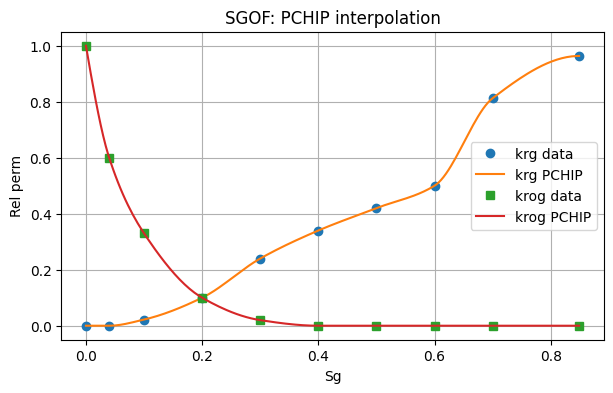

In [ ]:
# Paste into Colab (requires scipy)
import numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

S = df_sgof['Sat'].values
krg = df_sgof['kr1'].values
krog = df_sgof['kr2'].values

# choose grid to evaluate
Sgrid = np.linspace(S.min(), S.max(), 201)

# PCHIP (monotonic) for krg and krog
pkrg = PchipInterpolator(S, krg, extrapolate=False)
pkrog = PchipInterpolator(S, krog, extrapolate=False)

krg_pchip = pkrg(Sgrid)
krog_pchip = pkrog(Sgrid)

plt.figure(figsize=(7,4))
plt.plot(S, krg, 'o', label='krg data')
plt.plot(Sgrid, krg_pchip, '-', label='krg PCHIP')
plt.plot(S, krog, 's', label='krog data')
plt.plot(Sgrid, krog_pchip, '-', label='krog PCHIP')
plt.legend(); plt.grid(); plt.xlabel('Sg'); plt.ylabel('Rel perm'); plt.title('SGOF: PCHIP interpolation')
plt.show()


MEM and Fault Stability

Mean stresses (MPa): Sv= 48.300000000000004  SHmax= 42.0  Shmin= 33.599999999999994
sigma_n (MPa) = 37.275
tau (MPa) = 6.36528671781563


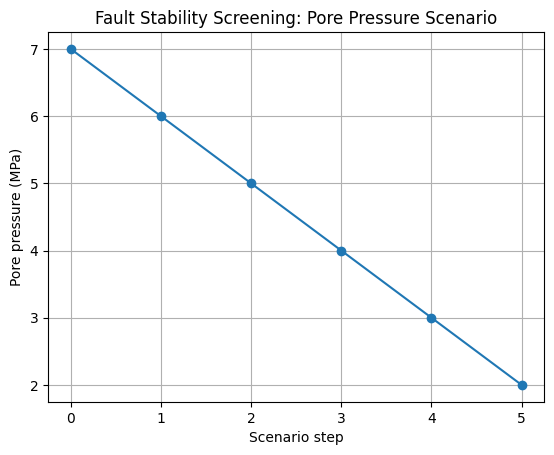

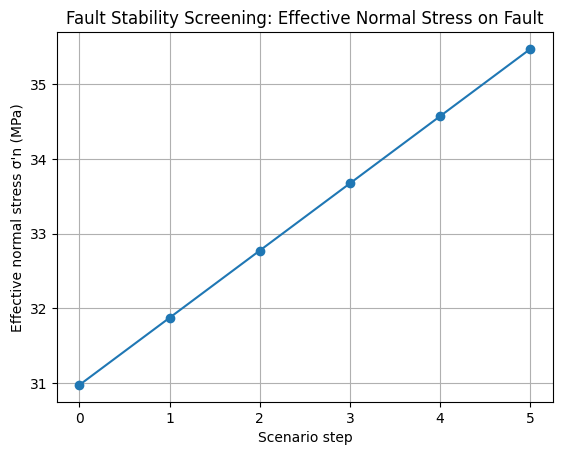

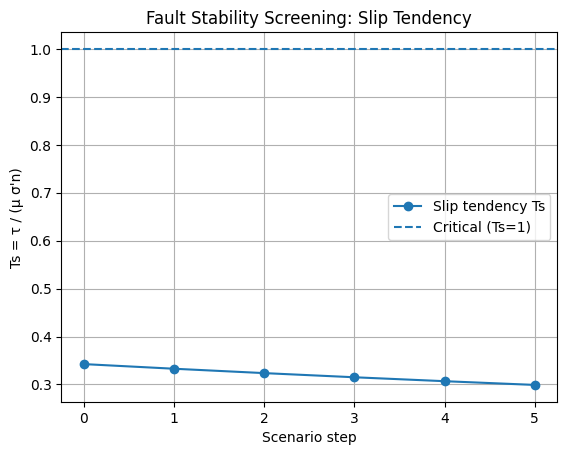

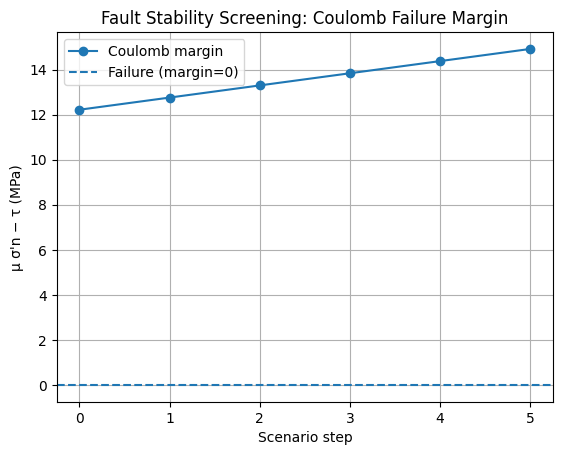

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Stress model (screening)
# -----------------------------
z_top, z_bottom = 2000, 2200
depth = np.linspace(z_top, z_bottom, 10)
depth_km = depth / 1000

Sv_grad, SHmax_grad, Shmin_grad = 23.0, 20.0, 16.0  # MPa/km
Sv = Sv_grad * depth_km
SHmax = SHmax_grad * depth_km
Shmin = Shmin_grad * depth_km

# Use mean stresses over interval (screening)
Sv0 = Sv.mean()
SH0 = SHmax.mean()
Sh0 = Shmin.mean()

print("Mean stresses (MPa): Sv=", Sv0, " SHmax=", SH0, " Shmin=", Sh0)

# -----------------------------
# 2) Fault geometry
# -----------------------------
dip_deg = 60.0                 # dip from horizontal
strike_rel_SHmax_deg = 0.0     # strike relative to SHmax direction (0 = strike || SHmax)
# Note: we will later sweep this to show sensitivity

dip = np.deg2rad(dip_deg)
phi = np.deg2rad(strike_rel_SHmax_deg)

# -----------------------------
# 3) Pore pressure scenarios (MPa)
# -----------------------------
# Option A: if you already have a pressure series from SPE3, reuse it:
# Pp = your_pressure_array_in_MPa
# time = np.arange(len(Pp))

# Option B (recommended for SPE9 screening now): define depletion/injection scenarios
Pp0 = 7.0  # MPa reference pore pressure (~1015 psi)
dP = np.array([0, -1, -2, -3, -4, -5])  # MPa depletion steps (negative = depletion)
Pp = Pp0 + dP
time = np.arange(len(Pp))

alpha = 0.9
mu = 0.6

# -----------------------------
# 4) Compute traction on fault plane
# Principal stresses aligned with axes:
# x = SHmax, y = Shmin, z = Sv
# Need unit normal vector n to the fault plane.
# Fault strike is horizontal; dip direction rotates with strike.
# -----------------------------
# Fault normal (one standard parameterization):
# For strike angle phi (from SHmax axis) and dip dip:
nx = -np.sin(dip) * np.sin(phi)
ny =  np.sin(dip) * np.cos(phi)
nz = -np.cos(dip)
n = np.array([nx, ny, nz])
n = n / np.linalg.norm(n)

# Stress tensor (compressive positive)
S = np.array([[SH0, 0.0, 0.0],
              [0.0, Sh0, 0.0],
              [0.0, 0.0, Sv0]])

# Traction vector on plane: t = S * n
t = S @ n

# Normal stress: sigma_n = n . t
sigma_n = float(n @ t)

# Shear traction magnitude: tau = || t - sigma_n * n ||
tau = float(np.linalg.norm(t - sigma_n * n))

# Now vary pore pressure through time: effective normal = sigma_n - alpha*Pp
sigma_n_eff = sigma_n - alpha * Pp
slip_tendency = tau / (mu * sigma_n_eff)
coulomb_margin = mu * sigma_n_eff - tau

print("sigma_n (MPa) =", sigma_n)
print("tau (MPa) =", tau)

# -----------------------------
# 5) Plots
# -----------------------------
plt.figure()
plt.plot(time, Pp, marker="o")
plt.xlabel("Scenario step")
plt.ylabel("Pore pressure (MPa)")
plt.title("Fault Stability Screening: Pore Pressure Scenario")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, sigma_n_eff, marker="o")
plt.xlabel("Scenario step")
plt.ylabel("Effective normal stress σ'n (MPa)")
plt.title("Fault Stability Screening: Effective Normal Stress on Fault")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, slip_tendency, marker="o", label="Slip tendency Ts")
plt.axhline(1.0, linestyle="--", label="Critical (Ts=1)")
plt.xlabel("Scenario step")
plt.ylabel("Ts = τ / (μ σ'n)")
plt.title("Fault Stability Screening: Slip Tendency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, coulomb_margin, marker="o", label="Coulomb margin")
plt.axhline(0.0, linestyle="--", label="Failure (margin=0)")
plt.xlabel("Scenario step")
plt.ylabel("μ σ'n − τ (MPa)")
plt.title("Fault Stability Screening: Coulomb Failure Margin")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
dP = np.array([-5, -4, -3, -2, -1, 0, +1, +2, +3, +4, +5])  # MPa
Pp = Pp0 + dP
time = np.arange(len(Pp))


In [3]:
print("sigma_n (MPa):", sigma_n)
print("tau (MPa):", tau)
print("sigma_n_eff range:", sigma_n_eff.min(), sigma_n_eff.max())
print("margin range:", coulomb_margin.min(), coulomb_margin.max())


sigma_n (MPa): 37.275
tau (MPa): 6.36528671781563
sigma_n_eff range: 30.974999999999998 35.475
margin range: 12.219713282184367 14.91971328218437


In [4]:
Pp_crit = (sigma_n - tau/mu) / alpha
print("Critical pore pressure for slip (MPa):", Pp_crit)
print("Current Pp0 (MPa):", Pp0)
print("Required ΔP to reach slip (MPa):", Pp_crit - Pp0)


Critical pore pressure for slip (MPa): 29.629098670711794
Current Pp0 (MPa): 7.0
Required ΔP to reach slip (MPa): 22.629098670711794


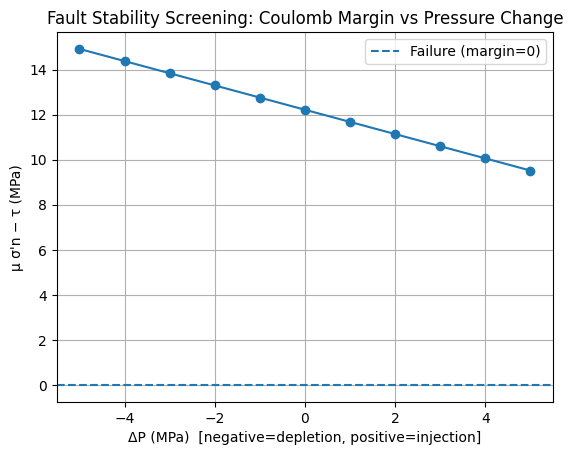

Pp_crit (MPa): 29.629098670711794
ΔP_crit (MPa): 22.629098670711794


In [5]:
# --- Pressure scenarios (both depletion and injection) ---
Pp0 = 7.0  # MPa
dP = np.array([-5, -4, -3, -2, -1, 0, +1, +2, +3, +4, +5])  # MPa
Pp = Pp0 + dP
time = np.arange(len(Pp))

sigma_n_eff = sigma_n - alpha * Pp
slip_tendency = tau / (mu * sigma_n_eff)
coulomb_margin = mu * sigma_n_eff - tau

plt.figure()
plt.plot(dP, coulomb_margin, marker="o")
plt.axhline(0.0, linestyle="--", label="Failure (margin=0)")
plt.xlabel("ΔP (MPa)  [negative=depletion, positive=injection]")
plt.ylabel("μ σ'n − τ (MPa)")
plt.title("Fault Stability Screening: Coulomb Margin vs Pressure Change")
plt.legend()
plt.grid(True)
plt.show()

Pp_crit = (sigma_n - tau/mu) / alpha
print("Pp_crit (MPa):", Pp_crit)
print("ΔP_crit (MPa):", Pp_crit - Pp0)


=== Orientation ===
Dip = 60.0 deg, Strike rel SHmax = 0.0 deg

=== Normal regime ===
sigma_n (MPa): 37.275 tau (MPa): 6.36528671781563
Pp_crit (MPa): 29.629098670711794   ΔP_crit (MPa): 22.629098670711794

=== Strike-slip regime ===
sigma_n (MPa): 37.275 tau (MPa): 6.36528671781563
Pp_crit (MPa): 29.629098670711794   ΔP_crit (MPa): 22.629098670711794


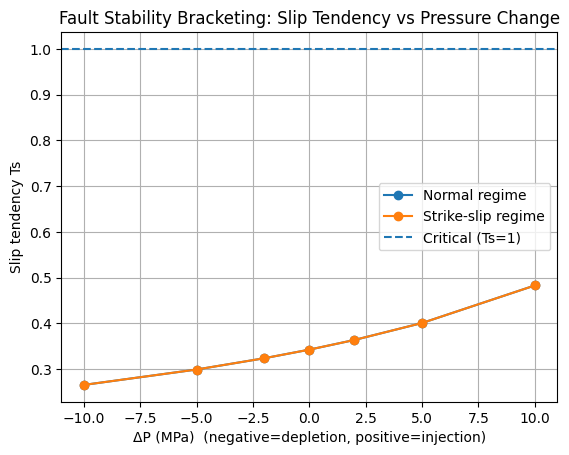

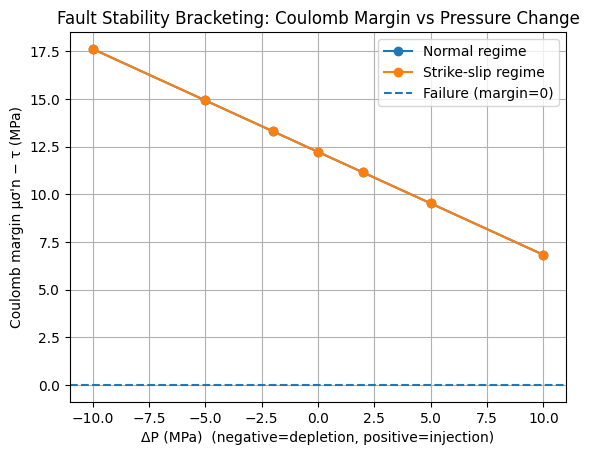

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Inputs: depth + stress magnitudes (from your MEM)
# -----------------------------
# Use the same depth interval as before
z_top, z_bottom = 2000, 2200
depth = np.linspace(z_top, z_bottom, 10)
depth_km = depth / 1000

Sv_grad, SHmax_grad, Shmin_grad = 23.0, 20.0, 16.0  # MPa/km
Sv = Sv_grad * depth_km
SH = SHmax_grad * depth_km
Sh = Shmin_grad * depth_km

Sv0 = Sv.mean()
SH0_base = SH.mean()
Sh0 = Sh.mean()

# -----------------------------
# Fault geometry (edit these if you want)
# -----------------------------
dip_deg = 60.0
strike_rel_SHmax_deg = 0.0   # 0..90 (0 = strike parallel to SHmax)

dip = np.deg2rad(dip_deg)
phi = np.deg2rad(strike_rel_SHmax_deg)

# Fault plane unit normal
nx = -np.sin(dip) * np.sin(phi)
ny =  np.sin(dip) * np.cos(phi)
nz = -np.cos(dip)
n = np.array([nx, ny, nz])
n = n / np.linalg.norm(n)

# -----------------------------
# Pressure scenario (both depletion and injection)
# -----------------------------
Pp0 = 7.0   # MPa baseline pore pressure (screening)
dP = np.array([-10, -5, -2, 0, +2, +5, +10])  # MPa
Pp = Pp0 + dP

alpha = 0.9
mu = 0.6

def fault_metrics(S_tensor, n, Pp, alpha, mu):
    t = S_tensor @ n
    sigma_n = float(n @ t)
    tau = float(np.linalg.norm(t - sigma_n * n))
    sigma_n_eff = sigma_n - alpha * Pp
    Ts = tau / (mu * sigma_n_eff)
    margin = mu * sigma_n_eff - tau
    Pp_crit = (sigma_n - tau/mu) / alpha
    dP_crit = Pp_crit - Pp0
    return sigma_n, tau, Ts, margin, Pp_crit, dP_crit

# -----------------------------
# Regime A: Normal faulting (Sv largest)
# -----------------------------
S_normal = np.array([[SH0_base, 0, 0],
                     [0, Sh0, 0],
                     [0, 0, Sv0]])

# -----------------------------
# Regime B: Strike-slip (SHmax largest)
# Make SHmax > Sv > Shmin (screening bracket)
# -----------------------------
SH0_ss = max(SH0_base, 1.15 * Sv0)  # ensure SHmax is largest
S_strikeslip = np.array([[SH0_ss, 0, 0],
                         [0, Sh0, 0],
                         [0, 0, Sv0]])

# Compute
sig_n_A, tau_A, Ts_A, M_A, Ppcrit_A, dPcrit_A = fault_metrics(S_normal, n, Pp, alpha, mu)
sig_n_B, tau_B, Ts_B, M_B, Ppcrit_B, dPcrit_B = fault_metrics(S_strikeslip, n, Pp, alpha, mu)

print("=== Orientation ===")
print(f"Dip = {dip_deg} deg, Strike rel SHmax = {strike_rel_SHmax_deg} deg")
print("\n=== Normal regime ===")
print("sigma_n (MPa):", sig_n_A, "tau (MPa):", tau_A)
print("Pp_crit (MPa):", Ppcrit_A, "  ΔP_crit (MPa):", dPcrit_A)

print("\n=== Strike-slip regime ===")
print("sigma_n (MPa):", sig_n_B, "tau (MPa):", tau_B)
print("Pp_crit (MPa):", Ppcrit_B, "  ΔP_crit (MPa):", dPcrit_B)

# -----------------------------
# Plots: Ts vs ΔP
# -----------------------------
plt.figure()
plt.plot(dP, Ts_A, marker="o", label="Normal regime")
plt.plot(dP, Ts_B, marker="o", label="Strike-slip regime")
plt.axhline(1.0, linestyle="--", label="Critical (Ts=1)")
plt.xlabel("ΔP (MPa)  (negative=depletion, positive=injection)")
plt.ylabel("Slip tendency Ts")
plt.title("Fault Stability Bracketing: Slip Tendency vs Pressure Change")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plots: Coulomb margin vs ΔP
# -----------------------------
plt.figure()
plt.plot(dP, M_A, marker="o", label="Normal regime")
plt.plot(dP, M_B, marker="o", label="Strike-slip regime")
plt.axhline(0.0, linestyle="--", label="Failure (margin=0)")
plt.xlabel("ΔP (MPa)  (negative=depletion, positive=injection)")
plt.ylabel("Coulomb margin μσ'n − τ (MPa)")
plt.title("Fault Stability Bracketing: Coulomb Margin vs Pressure Change")
plt.grid(True)
plt.legend()
plt.show()


In [10]:
dip_list = np.linspace(30, 80, 11)        # degrees
strike_list = np.linspace(0, 90, 19)      # degrees
Pp0 = 7.0
alpha = 0.9
mu = 0.6

def get_normal_vector(dip_deg, strike_rel_deg):
    dip = np.deg2rad(dip_deg)
    phi = np.deg2rad(strike_rel_deg)
    nx = -np.sin(dip) * np.sin(phi)
    ny =  np.sin(dip) * np.cos(phi)
    nz = -np.cos(dip)
    n = np.array([nx, ny, nz])
    return n / np.linalg.norm(n)

def dPcrit_for_orientation(S_tensor, n):
    t = S_tensor @ n
    sigma_n = float(n @ t)
    tau = float(np.linalg.norm(t - sigma_n * n))
    Pp_crit = (sigma_n - tau/mu) / alpha
    return Pp_crit - Pp0

best_A = {"dPcrit": 1e9}
best_B = {"dPcrit": 1e9}

for dip_deg in dip_list:
    for strike_deg in strike_list:
        n = get_normal_vector(dip_deg, strike_deg)
        dP_A = dPcrit_for_orientation(S_normal, n)
        dP_B = dPcrit_for_orientation(S_strikeslip, n)

        if dP_A < best_A["dPcrit"]:
            best_A = {"dPcrit": dP_A, "dip": dip_deg, "strike": strike_deg}
        if dP_B < best_B["dPcrit"]:
            best_B = {"dPcrit": dP_B, "dip": dip_deg, "strike": strike_deg}

print("Worst-case (minimum ΔPcrit) — Normal regime:", best_A)
print("Worst-case (minimum ΔPcrit) — Strike-slip regime:", best_B)


Worst-case (minimum ΔPcrit) — Normal regime: {'dPcrit': 22.629098670711794, 'dip': np.float64(60.0), 'strike': np.float64(0.0)}
Worst-case (minimum ΔPcrit) — Strike-slip regime: {'dPcrit': 19.164123784451213, 'dip': np.float64(80.0), 'strike': np.float64(30.0)}


In [11]:
mu_list = [0.6, 0.5, 0.4]
results = []

for mu_test in mu_list:
    def dPcrit_for_orientation_mu(S_tensor, n, mu):
        t = S_tensor @ n
        sigma_n = float(n @ t)
        tau = float(np.linalg.norm(t - sigma_n * n))
        Pp_crit = (sigma_n - tau/mu) / alpha
        return Pp_crit - Pp0

    bestA = {"dPcrit": 1e9}
    bestB = {"dPcrit": 1e9}

    for dip_deg in dip_list:
        for strike_deg in strike_list:
            n = get_normal_vector(dip_deg, strike_deg)
            dP_A = dPcrit_for_orientation_mu(S_normal, n, mu_test)
            dP_B = dPcrit_for_orientation_mu(S_strikeslip, n, mu_test)
            if dP_A < bestA["dPcrit"]:
                bestA = {"mu": mu_test, "dPcrit": dP_A, "dip": dip_deg, "strike": strike_deg}
            if dP_B < bestB["dPcrit"]:
                bestB = {"mu": mu_test, "dPcrit": dP_B, "dip": dip_deg, "strike": strike_deg}

    results.append((bestA, bestB))

results


[({'mu': 0.6,
   'dPcrit': 22.629098670711794,
   'dip': np.float64(60.0),
   'strike': np.float64(0.0)},
  {'mu': 0.6,
   'dPcrit': 19.164123784451213,
   'dip': np.float64(80.0),
   'strike': np.float64(30.0)}),
 ({'mu': 0.5,
   'dPcrit': 20.271585071520818,
   'dip': np.float64(60.0),
   'strike': np.float64(0.0)},
  {'mu': 0.5,
   'dPcrit': 15.6493755285377,
   'dip': np.float64(80.0),
   'strike': np.float64(30.0)}),
 ({'mu': 0.4,
   'dPcrit': 16.521444488461395,
   'dip': np.float64(55.0),
   'strike': np.float64(0.0)},
  {'mu': 0.4,
   'dPcrit': 10.17695598422397,
   'dip': np.float64(80.0),
   'strike': np.float64(35.0)})]

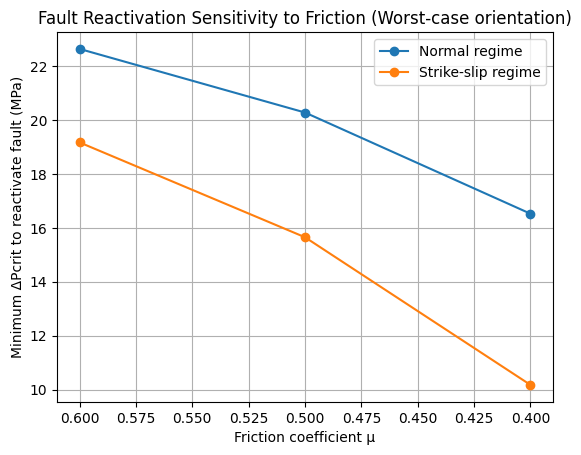

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mu_vals = np.array([0.6, 0.5, 0.4])
dP_normal = np.array([22.629098670711794, 20.271585071520818, 16.521444488461395])
dP_ss = np.array([19.164123784451213, 15.6493755285377, 10.17695598422397])

plt.figure()
plt.plot(mu_vals, dP_normal, marker="o", label="Normal regime")
plt.plot(mu_vals, dP_ss, marker="o", label="Strike-slip regime")
plt.gca().invert_xaxis()  # optional: shows decreasing mu to the right if you prefer
plt.xlabel("Friction coefficient μ")
plt.ylabel("Minimum ΔPcrit to reactivate fault (MPa)")
plt.title("Fault Reactivation Sensitivity to Friction (Worst-case orientation)")
plt.grid(True)
plt.legend()
plt.show()
